# Which Promotion Bites Best? A Data-Driven Marketing Decision

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

The goal of this A/B testing project is to analyze the collected sales data and determine:
- Whether there are statistically significant differences in sales between the three promotions
- Which specific promotions perform better or worse than others

The analysis follows standard A/B testing procedures including:
- Data exploration & cleaning  
- Assumption checks (normality, variance)  
- Statistical testing (ANOVA & Kruskal-Wallis)  
- Post-hoc comparisons (Tukey HSD)


In [263]:
#import libraries
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import shapiro

In [6]:
#reading the data
df = pd.read_csv("WA_Marketing-Campaign.csv")

**Columns**

- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [10]:
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


## Exploratory Data Analysis

Before diving into statistical testing, I explored the dataset to understand the distribution and characteristics of the variables.

To support the analysis, I also created a summary table with additional calculated features such as:
- Total number of records per promotion
- Number of unique stores per promotion
- Average store age per promotion
- Distribution of market sizes (Large / Medium / Small)

This provides important context for how the promotion strategies are spread across store types and regions, and helps identify any imbalances in the data before testing begins.


In [278]:
#basic sales stats
sales_summary = df.groupby('Promotion')[['SalesInThousands', 'AgeOfStore']].agg({
    'SalesInThousands': ['sum', 'mean', 'count'],
    'AgeOfStore': 'mean'
}).reset_index()

#renaming colunns
sales_summary.columns = ['Promotion', 'TotalSales', 'AverageSales', 'Count', 'AvgStoreAge']

#get number of unique stores per promotion
store_counts = df.groupby('Promotion')['LocationID'].nunique().reset_index()
store_counts.columns = ['Promotion', 'NumberOfStores']

#count of market sizes per promo
market_sizes = pd.crosstab(df['Promotion'], df['MarketSize']).reset_index()

#merging everything into one table
summary = sales_summary.merge(store_counts, on='Promotion')
summary = summary.merge(market_sizes, on='Promotion')

#rounding values
summary = summary.round({
    'TotalSales': 2,
    'AverageSales': 2,
    'AvgStoreAge': 1
})

summary


,Promotion,TotalSales,AverageSales,Count,AvgStoreAge,NumberOfStores,Large,Medium,Small
0,1,9993.03,58.10,172,8.3,43,56,96,20
1,2,8897.93,47.33,188,8.0,47,64,108,16
2,3,10408.52,55.36,188,9.2,47,48,116,24


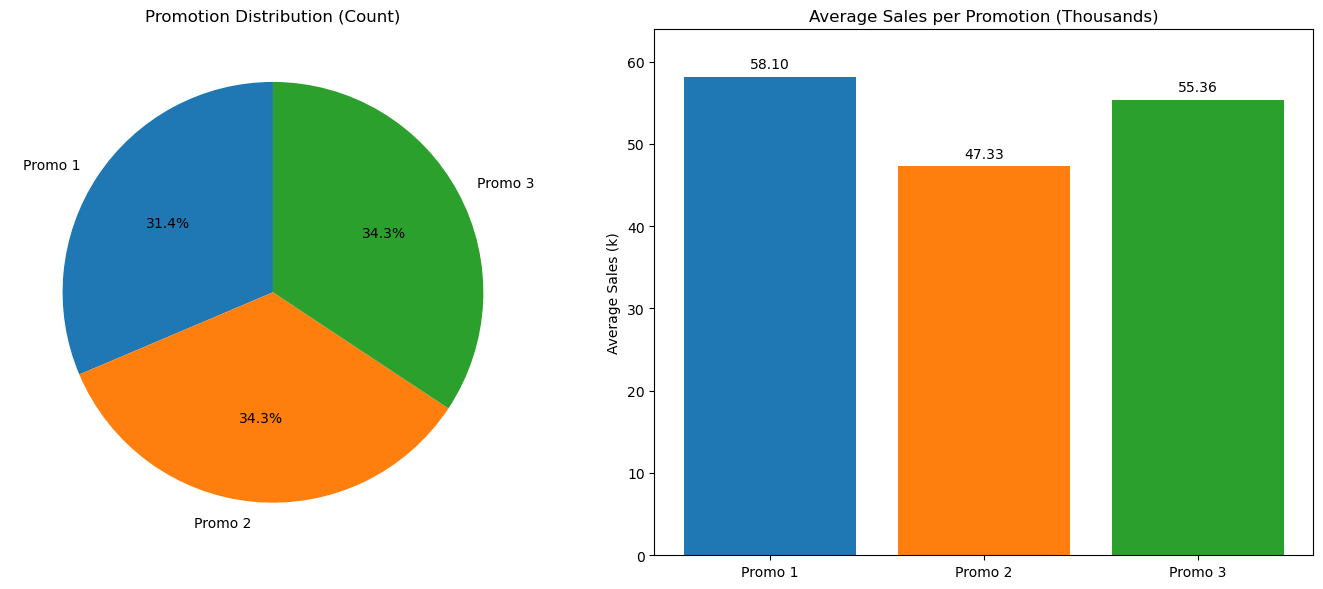

In [280]:
promo_counts = df['Promotion'].value_counts().sort_index()
promo_avg_sales = df.groupby('Promotion')['SalesInThousands'].mean().sort_index()

labels = [f'Promo {i}' for i in promo_counts.index]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#pie Chart: Promotion Distribution (Count)
axes[0].pie(promo_counts, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Promotion Distribution (Count)')

#bar Chart: Average Sales per Promotion
bars = axes[1].bar(labels, promo_avg_sales, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_title('Average Sales per Promotion (Thousands)')
axes[1].set_ylabel('Average Sales (k)')
axes[1].set_ylim(0, promo_avg_sales.max() * 1.1)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height * 1.02, f'{height:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


From the charts above:

- Promotion 1 had the smallest sample size, yet was still outperforming Promotion 2 in total sales.
- Promotion 3 had the same number of entries as Promotion 2, but was generating significantly higher total sales.
- Promotion 2, despite having the most exposure, was resulting in the lowest overall sales.

This suggests that sample size alone does not explain performance, some promotions are clearly more effective than others.

 Next, I'll break down sales by week to see if certain promotions start strong or gain momentum over time.


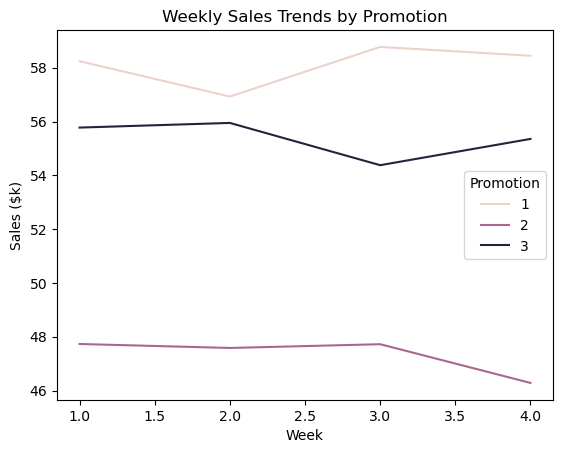

In [282]:
sns.lineplot(data=df, x='week', y='SalesInThousands', hue='Promotion', ci=None)
plt.title('Weekly Sales Trends by Promotion')
plt.xlabel('Week')
plt.ylabel('Sales ($k)')
plt.show()

From the weekly sales chart, there doesn’t appear to be a strong shared trend across the three promotions. Each seems to move on its own timeline, with no clear pattern that connects their weekly ups or downs. That said, the overall performance differences are still very visible. **Promotion 1** consistently brings in the highest sales, followed by **Promotion 3**, while **Promotion 2** lags noticeably behind both.

Now that we’ve seen how promotions behave over time, let’s take a closer look at how market size might influence these results.

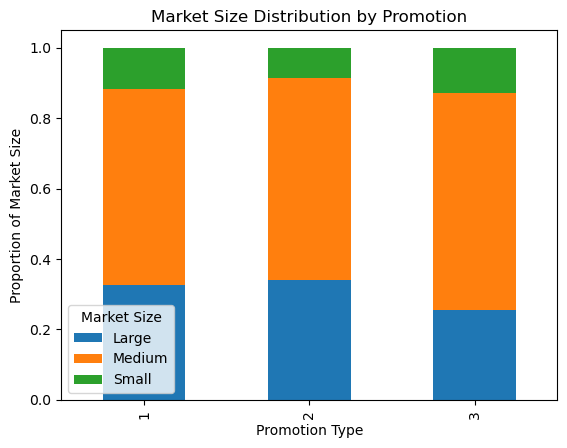

In [54]:
market_promo = pd.crosstab(df['Promotion'], df['MarketSize'], normalize='index')
market_promo.plot(kind='bar', stacked=True)
plt.title('Market Size Distribution by Promotion')
plt.xlabel('Promotion Type')
plt.ylabel('Proportion of Market Size')
plt.legend(title='Market Size')
plt.show()

Most of the promotions were distributed in medium-sized markets, which could suggest that the company either prioritized mid-tier locations for testing or simply had more medium markets available in the dataset. This uneven distribution doesn’t necessarily “break” the analysis, but it does mean we should be a little cautious when generalizing results across all market sizes, especially if we want to assume our sample is fully representative.

As for its effect on normal distribution: having more data from one type of market (like medium) doesn't directly cause non-normality, but it can skew the data if that segment behaves very differently from others (e.g. maybe small markets underperform, or large ones overperform). So it's something to keep in mind when interpreting results, but not automatically a violation on its own.

Now, let’s turn to the age of the store to see if that variable plays a role in how each promotion performed.

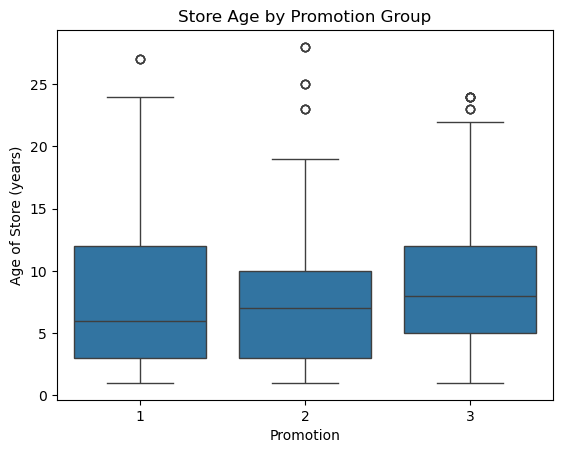

In [58]:
sns.boxplot(x='Promotion', y='AgeOfStore', data=df)
plt.title('Store Age by Promotion Group')
plt.xlabel('Promotion')
plt.ylabel('Age of Store (years)')
plt.show()

The boxplot of store age across the three promotions shows some subtle but interesting differences:

- Promotion 3 was tested in the oldest stores on average — it had the highest median store age.
- Promotion 2 sits in the middle, while Promotion 1 was mostly tested in younger stores.
- Promotion 1 also had the widest range of store ages, as shown by the larger box and whiskers. This means its promotion group included both very new and older stores, creating more variability in this feature.
- Promotions 2 and 3 were more tightly clustered around their medians, suggesting more consistent store ages.

Despite being tested in generally younger and more varied stores, Promotion 1 still outperformed the others. This suggests that store age might not be a strong driver of promotion success in this dataset, or at least, not enough to override the impact of the campaign itself.

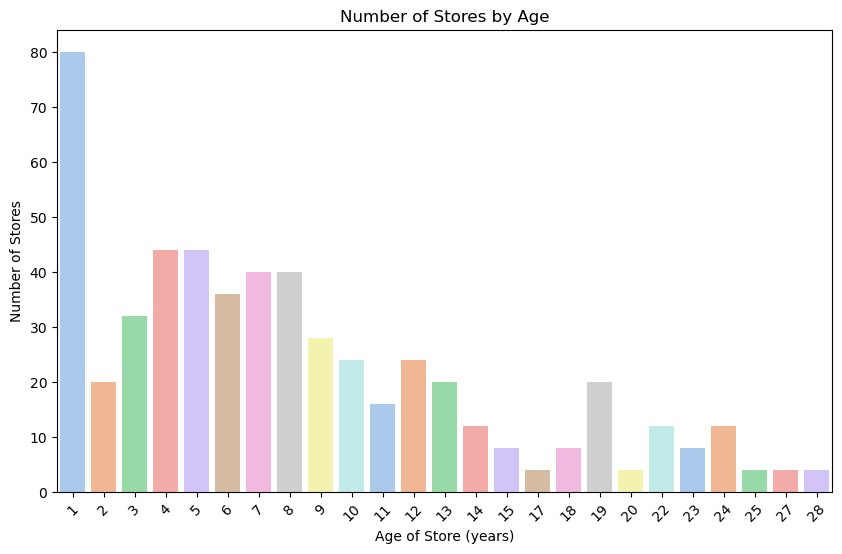

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(x='AgeOfStore', data=df, palette='pastel')
plt.title('Number of Stores by Age')
plt.xlabel('Age of Store (years)')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.show()


The bar chart shows that the majority of stores in the dataset are **13 years old or younger**, with a noticeable spike at **1 year old**, the most common store age by far.

This suggests that many promotions were tested in relatively new stores. While this doesn’t necessarily bias the results, it’s something to be aware of when thinking about how representative the sample is. If newer stores tend to behave differently (e.g. better foot traffic, newer staff, different customer habits), it could influence the effectiveness of certain promotions.

At this point, store age doesn’t appear to have a strong visual relationship to performance, but it’s still valuable context for interpreting the overall picture.


## Assumption Analysis

Before applying ANOVA, I began by checking whether the data was meeting two key assumptions that allow the test to function properly and produce meaningful results:

- **Assessing Normality:** This involves checking whether the sales distributions within each promotion group are following a roughly normal, bell-shaped curve. Normality is important because ANOVA is designed under the assumption that data within each group is normally distributed.

- **Evaluating Homogeneity of Variance:** Here, I am looking at whether the spread (or variance) of sales is consistent across all promotion groups. If one group has sales values that vary much more than the others, it could skew the ANOVA results and lead to unreliable conclusions.

By checking these assumptions before moving forward, I am making sure that the statistical tests I apply are built on solid ground. This helps ensure that the p-values I interpret are trustworthy and that any conclusions I draw about differences in promotion performance are backed by reliable evidence.


### Normality Assumption

One of the core assumptions of ANOVA is that the **sales distribution within each promotion group** (Promo 1, Promo 2, Promo 3) is approximately **normal** — meaning, it roughly follows a bell-shaped curve.

To explore this, I’m checking normality in two ways:

- **Visual check:** I’ll use **Q-Q plots** for each group to visually inspect how closely the data aligns with a normal distribution.

- **Statistical test:** I’ll apply the **Shapiro-Wilk test**, which formally tests for normality. If the p-value is below 0.05, we reject the idea that the data is normally distributed.

If the normality assumption doesn't hold for one or more groups, I’ll use a non-parametric alternative: the **Kruskal-Wallis test** to ensure the analysis remains statistically valid.

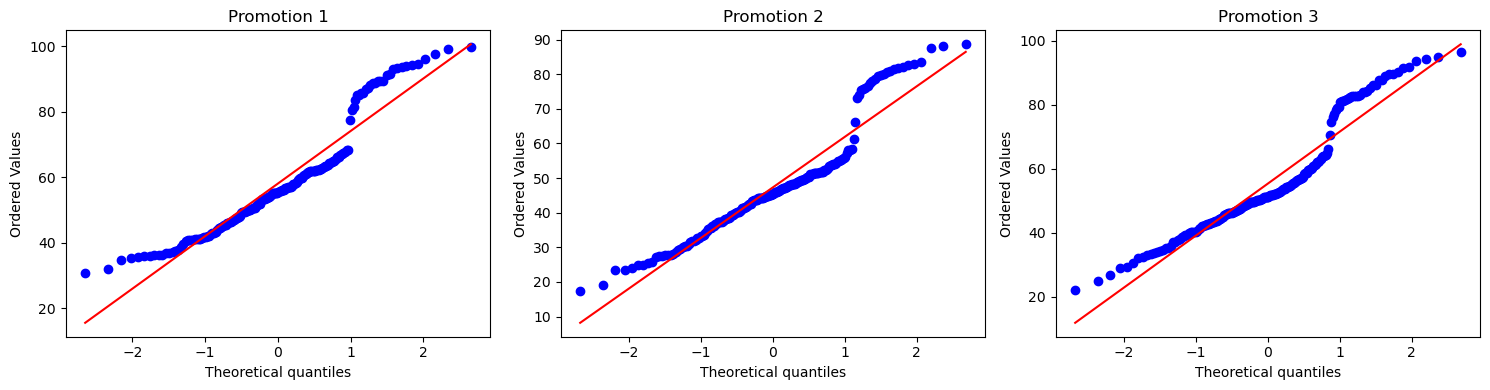

In [186]:
#QQ plots
promos = sorted(df['Promotion'].unique())

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, promo in enumerate(promos):
    stats.probplot(df[df['Promotion'] == promo]['SalesInThousands'], dist="norm", plot=axes[i])
    axes[i].set_title(f'Promotion {promo}')

plt.tight_layout()
plt.show()


I’m using Q-Q plots to get a visual sense of how closely each promotion group is following a normal distribution.

In all three promotions, the points are staying fairly close to the red diagonal line through the middle of the plot, suggesting that the main body of the data is behaving normally. However, I’m also noticing a consistent S-shape forming across the groups:

- At the **lower left** and **upper right** corners — representing the lowest and highest sales values — the points are curving away from the line.
- This bend is becoming more noticeable at the upper end, especially around **60k in sales and above**.

Even though these deviations are showing up at the tails, the central alignment is staying strong. Based on this, I’m considering the normality assumption to be **mostly satisfied**, especially since ANOVA is known for handling small departures from normality when the sample size is large.



In [203]:
#shapiro-wilk test
from scipy.stats import shapiro
for promo in promos:
    sales = df[df['Promotion'] == promo]['SalesInThousands']
    stat, p = shapiro(sales)
    print(f'Promo {promo} — W={stat:.3f}, p-value={p}')


Promo 1 — W=0.915, p-value=1.9772645044478197e-08
Promo 2 — W=0.915, p-value=5.4570996662742616e-09
Promo 3 — W=0.921, p-value=1.4994659261192486e-08


I’m testing each promotion group using the Shapiro-Wilk test to check whether the data is following a normal distribution.

- If all p-values > 0.05: all groups are likely normally distributed 
- If any p-value < 0.05:  ANOVA’s normality assumption is violated 

| Promo | W-statistic | p-value |
|-------|-------------|---------|
|   1   |   0.915     |  1.98e-08 |
|   2   |   0.915     |  5.46e-09 |
|   3   |   0.921     |  1.50e-08 |


Since all p-values are falling below the 0.05 threshold, I’m rejecting the null hypothesis for all three groups.  
This is telling me that **none of the groups are normally distributed**, which means the normality assumption for ANOVA is being violated.

Still, because the group sizes are staying relatively balanced and the overall sample size is moderate, I’m choosing to move forward with ANOVA, while also running the **Kruskal-Wallis test** as a non-parametric backup.

In [148]:
#run Kruskal Wallis test
from scipy.stats import kruskal

promo1 = df[df['Promotion'] == 1]['SalesInThousands']
promo2 = df[df['Promotion'] == 2]['SalesInThousands']
promo3 = df[df['Promotion'] == 3]['SalesInThousands']

stat, p = kruskal(promo1, promo2, promo3)

print("Kruskal-Wallis Test")
print("H-statistic:", round(stat, 3))
print("p-value:", p)


Kruskal-Wallis Test
H-statistic: 53.295
p-value: 2.674186626669782e-12



- H₀: If p-values > 0.05, The distributions of sales are the same across all promos
- H₁: If p-value < 0.05, At least one promo has a different sales distribution


The **p-value: 2.674186626669782e-12** is significantly less than 0.05, so I **reject the null hypothesis**. This confirms that at least one promotion leads to a significantly different sales distribution.

After running the test, I’m getting a **p-value of 2.67e-12**, which is far below the 0.05 threshold.  
This is leading me to **reject the null hypothesis**, confirming that at least one promotion is showing a significantly different sales distribution compared to the others.

This is aligning with what I saw in earlier visualizations, suggesting a real difference in performance between the campaigns.

### Homogeneity of Variance

Another key assumption behind ANOVA is that the **variance of sales**, meaning the spread of values is staying roughly equal across all promotion groups.

I’m checking this assumption using two approaches:

- Visual check with boxplots: I’m starting by looking at boxplots for each group side by side, noticing whether the spreads look similar or if any group appears noticeably wider or more compressed than the others. This helps me get a quick visual sense of whether the data is balanced or skewed in its variability.

- Statistical check with Levene’s Test: I’m following up with Levene’s test, which is specifically designed for checking **equality of variances** between groups.  
  - If the p-value is **above 0.05**, I’ll be treating the variances as similar enough to meet the assumption.
  - If the p-value is **below 0.05**, I’ll be considering the variances too different, meaning ANOVA's assumption has been violated.

Together, these two checks are helping me decide whether I can trust ANOVA to handle this data reliably, or whether I need to lean more heavily on non-parametric results like Kruskal-Wallis.

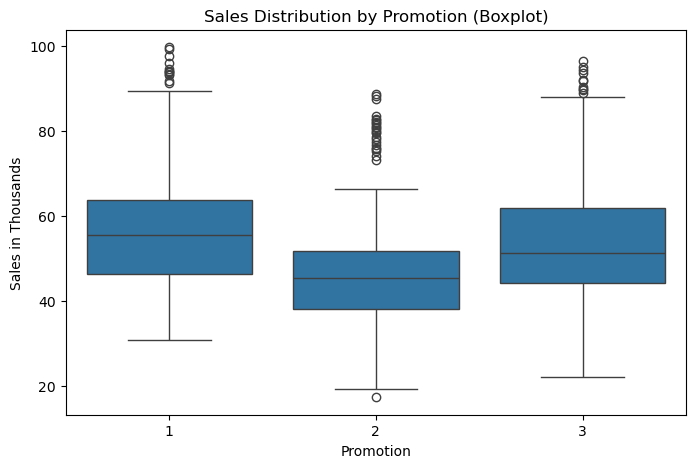

In [222]:
#box plot
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Promotion', y='SalesInThousands')
plt.title('Sales Distribution by Promotion (Boxplot)')
plt.xlabel('Promotion')
plt.ylabel('Sales in Thousands')
plt.show()


I’m using side-by-side boxplots to visually check whether the sales variance looks similar across the three promotions.

The **boxes themselves** which represent the middle 50% of values, are roughly the same size across all three groups. This is suggesting that the central spread (interquartile range) is fairly balanced.

Looking closer:

- **Promotion 2** is showing the **most outliers**, with many small dots scattered above the upper whisker. This means it has more extreme values outside the main range, even though its core spread is tight.
- **Promotion 3** has the **longest whiskers**, indicating a wider overall range of values, even though its box is still narrow.
- **Promotion 2** has the **shortest whiskers**, suggesting that most of its data is tightly clustered.

While none of these differences are extreme, they’re hinting that **the groups may not have perfectly equal variance**, which is why I’m following up with Levene’s Test to check more formally.

In [95]:
#levene test
from scipy.stats import levene

grouped = [df[df['Promotion'] == p]['SalesInThousands'] for p in promos]
stat, p = levene(*grouped)
print(f"Levene's Test — Statistic={stat:.3f}, p-value={p:.4f}")


Levene's Test — Statistic=1.270, p-value=0.2818


I’m using **Levene’s Test** to check whether the **sales variances** are staying equal across all three promotion groups — a key assumption for running ANOVA.

- H₀: If the p-value is > 0.05, I’m assuming the variances are equal, the groups are homogeneous.
- H₁: If the p-value is < 0.05, I’m considering the variances unequal, the assumption is violated.

After running the test, I’m getting a **p-value of 0.2818**, which is well above the 0.05 threshold.  
Because of this, I’m **failing to reject the null hypothesis**, meaning I’m treating the group variances as statistically equal.

This is confirming that the **homogeneity of variance assumption is satisfied**, so I’m moving forward with a **standard one-way ANOVA** confidently.


## ANOVA testing
Having checked the key assumptions: **normality** and **equal variances**, I’m now proceeding to run a **one-way ANOVA** to compare the **average sales** across the three promotion groups.

Instead of running multiple pairwise t-tests (like Promo 1 vs 2, 1 vs 3, and 2 vs 3), which would be increasing the risk of **Type 1 errors** (false positives), ANOVA lets me look at all groups together at once. This helps protect against drawing misleading conclusions by testing many comparisons separately.

Setting up the hypotheses:

- H₀:If the p-value is **above 0.05** The mean sales are the same across all three promotions, meaning, promotion type doesn’t have a statistically significant effect on sales.
- H₁:If the p-value is **below 0.05** At least one promotion has a different average sales value, suggesting the promotion type does affect sales.



In [123]:
from scipy.stats import f_oneway

#get sales for each promotion group
promo1 = df[df['Promotion'] == 1]['SalesInThousands']
promo2 = df[df['Promotion'] == 2]['SalesInThousands']
promo3 = df[df['Promotion'] == 3]['SalesInThousands']

#run ANOVA
f_stat, p_val = f_oneway(promo1, promo2, promo3)

print("ANOVA Results")
print("F-statistic:", round(f_stat, 3))
print("p-value:", p_val)


ANOVA Results
F-statistic: 21.953
p-value: 6.765849261408714e-10


The p-value of 6.77e-10 is sitting far below the 0.05 threshold, so I’m rejecting the null hypothesis.  
This is telling me that there is a **statistically significant difference in average sales** between at least one pair of promotions.

In other words, not all promotions are performing equally, at least one is standing out.To pinpoint which promotions are different from each other, I’m moving on to run the **Tukey HSD post-hoc test** next.


### Tukey HSD

After finding a significant result in the ANOVA test, I used the **Tukey Honestly Significant Difference (HSD)** test to explore **which specific promotion pairs** have statistically different mean sales.
Tukey HSD is a post-hoc test that compares **all possible group pairs** while controlling for the **family-wise error rate**.  
This helps avoid false positives when making multiple comparisons.

**How it works:**  
- It calculates the difference in mean sales between each pair of promotions  
- It provides a 95% confidence interval (CI) for each difference  
- If the CI **does not include 0**, the difference is considered **statistically significant**  
- It also reports an **adjusted p-value** to account for multiple testing

In [325]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['SalesInThousands'], groups=df['Promotion'], alpha=0.05)
print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


The Tukey HSD test is showing clear differences between some of the promotion groups.  

Looking at the comparison between Promotion 1 and Promotion 2, the mean difference in sales is around **-10.77k**, with a confidence interval ranging from **-14.77k to -6.77k**. Since this interval doesn’t include zero and the adjusted p-value is essentially zero, this difference is statistically significant. This is telling me that Promotion 1 is performing **significantly better** than Promotion 2.

When comparing Promotion 1 and Promotion 3, the mean difference is much smaller, around **-2.73k**, and the confidence interval spans from **-6.74k to 1.27k**. Because this range includes zero and the p-value is quite high, I’m concluding that there’s **no statistically significant difference** between these two promotions.

Finally, the comparison between Promotion 2 and Promotion 3 reveals a mean difference of about **8.04k**, with a confidence interval from **4.12k to 11.95k**, and again, a very low p-value. This confirms that Promotion 3 is also performing **significantly better** than Promotion 2.

In short, both Promotion 1 and Promotion 3 are outperforming Promotion 2 by a meaningful margin, while there’s no strong evidence that Promotions 1 and 3 differ from each other.

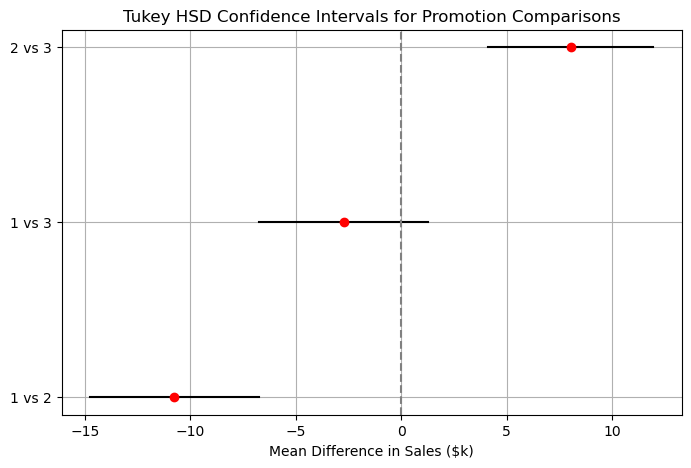

In [255]:
#Tukey results for plotting
comparisons = ['1 vs 2', '1 vs 3', '2 vs 3']
meandiffs = [-10.77, -2.73, 8.04]
lower_bounds = [-14.77, -6.74, 4.12]
upper_bounds = [-6.77, 1.27, 11.95]


plt.figure(figsize=(8, 5))


for i in range(len(comparisons)):
    plt.plot([lower_bounds[i], upper_bounds[i]], [i, i], color='black')  #CI line
    plt.plot(meandiffs[i], i, 'ro')  #Mean diff point

plt.axvline(0, color='gray', linestyle='--')  #0 line = no difference
plt.yticks(range(len(comparisons)), comparisons)
plt.xlabel('Mean Difference in Sales ($k)')
plt.title('Tukey HSD Confidence Intervals for Promotion Comparisons')
plt.grid(True)
plt.show()

This plot is showing the confidence intervals for the mean differences between each pair of promotion groups.

Each horizontal line represents the difference in average sales between two promotions. The black dot marks the **mean difference**, and the thin line stretching across is the **95% confidence interval** for that difference. If a line **crosses the vertical line at 0**, it means that difference is **not statistically significant** — because zero is a possible value for the true difference.

From the graph, the intervals for **Promotion 1 vs Promotion 2** and **Promotion 2 vs Promotion 3** do **not cross zero**, which matches the earlier result, both comparisons are statistically significant.The interval for **Promotion 1 vs Promotion 3** **does cross zero**, confirming that there’s **no significant difference** between these two promotions. The direction of the difference matters too: since the lines for the comparisons with Promotion 2 are entirely **above or below zero**, it’s visually reinforcing that **Promotion 2 is consistently underperforming**, while Promotions 1 and 3 are closer together.

So this graph is just another way of saying what the Tukey table told me, but seeing it visually helps make the distinctions clearer.


##  Recommendation
After analyzing the sales performance across the three promotions, I’m seeing clear evidence that **Promotion 2 is underperforming**. Both Promotion 1 and Promotion 3 consistently generate higher average sales, and the differences are statistically significant. However, there’s no meaningful difference between Promotion 1 and Promotion 3 themselves since they’re performing at a similar level.

Based on this, I would **recommend discontinuing Promotion 2** in its current form. Between Promotion 1 and 3, either could be a strong option moving forward. Since their performance is statistically similar, the decision between them could be based on **other factors** such as cost-efficiency, branding alignment, or customer engagement.

If possible, it might also be valuable to **experiment further** by testing refinements of Promotion 1 and 3 individually, or exploring how they perform in different market segments. But for now, the data makes it clear: Promotion 2 is not a competitive choice.